In [1]:
# First, import the necessary modules and functions
import os
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from myst_nb import glue
from nilearn import plotting
from repo2data.repo2data import Repo2Data

import nimare

# Install the data if running locally, or points to cached data if running on neurolibre
DATA_REQ_FILE = os.path.join("../binder/data_requirement.json")
FIG_DIR = os.path.abspath("../images")

# Download data
repo2data = Repo2Data(DATA_REQ_FILE)
data_path = repo2data.install()
data_path = os.path.join(data_path[0], "data")

# Now, load the Datasets we will use in this chapter
sleuth_dset1 = nimare.dataset.Dataset.load(os.path.join(data_path, "sleuth_dset1.pkl.gz"))
sleuth_dset2 = nimare.dataset.Dataset.load(os.path.join(data_path, "sleuth_dset2.pkl.gz"))
neurosynth_dset = nimare.dataset.Dataset.load(os.path.join(data_path, "neurosynth_dataset.pkl.gz"))

/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


---- repo2data starting ----
/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/repo2data
Config from file :
../binder/data_requirement.json
Destination:
./../data/nimare-paper

Info : ./../data/nimare-paper already downloaded


In [2]:
from nimare.meta import kernel

mkda_kernel = kernel.MKDAKernel(r=10)
mkda_ma_maps = mkda_kernel.transform(sleuth_dset1)
kda_kernel = kernel.KDAKernel(r=10)
kda_ma_maps = kda_kernel.transform(sleuth_dset1)
ale_kernel = kernel.ALEKernel(sample_size=20)
ale_ma_maps = ale_kernel.transform(sleuth_dset1)

In [3]:
# Here we delete the recent variables for the sake of reducing memory usage
del mkda_kernel, kda_kernel, ale_kernel

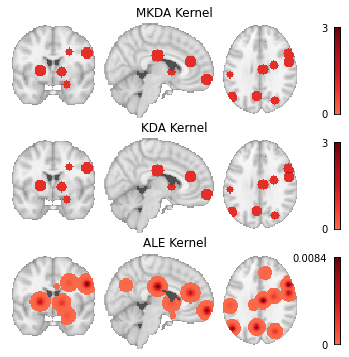

In [4]:
# Generate figure
study_idx = 10  # a study with overlapping kernels
max_value = np.max(kda_ma_maps[study_idx].get_fdata()) + 1

ma_maps = {
    "MKDA Kernel": mkda_ma_maps[study_idx],
    "KDA Kernel": kda_ma_maps[study_idx],
    "ALE Kernel": ale_ma_maps[study_idx],
}

fig, axes = plt.subplots(nrows=3, figsize=(6, 6))

for i_meta, (name, img) in enumerate(ma_maps.items()):
    if "ALE" in name:
        vmax = None
    else:
        vmax = max_value

    display = plotting.plot_stat_map(
        img,
        annotate=False,
        axes=axes[i_meta],
        cmap="Reds",
        cut_coords=[5, 0, 29],
        draw_cross=False,
        figure=fig,
        vmax=vmax,
    )
    axes[i_meta].set_title(name)

    colorbar = display._cbar
    colorbar_ticks = colorbar.get_ticks()
    if colorbar_ticks[0] < 0:
        new_ticks = [colorbar_ticks[0], 0, colorbar_ticks[-1]]
    else:
        new_ticks = [colorbar_ticks[0], colorbar_ticks[-1]]
    colorbar.set_ticks(new_ticks, update_ticks=True)

glue("figure_ma_maps", fig, display=False)

In [5]:
# Here we delete the recent variables for the sake of reducing memory usage
del mkda_ma_maps, kda_ma_maps, ale_ma_maps

In [6]:
from nimare.meta.cbma import mkda

mkdad_meta = mkda.MKDADensity(null_method="approximate")
mkdad_results = mkdad_meta.fit(sleuth_dset1)

In [7]:
print(mkdad_results)

In [8]:
print(mkdad_meta.results)

In [9]:
pprint(mkdad_results.maps)

{'p': array([1., 1., 1., ..., 1., 1., 1.]),
 'stat': array([0., 0., 0., ..., 0., 0., 0.]),
 'z': array([0., 0., 0., ..., 0., 0., 0.])}


In [10]:
mkdad_img = mkdad_results.get_map("z", return_type="image")
print(mkdad_img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91)
affine: 
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code     

In [11]:
mkdad_results.save_maps(output_dir=data_path, prefix="MKDADensity")

In [12]:
mkdad_meta.save(os.path.join(data_path, "MKDADensity.pkl.gz"))

In [13]:
# Here we delete the recent variables for the sake of reducing memory usage
del mkdad_meta, mkdad_results

In [14]:
# These two approaches (initializing the kernel ahead of time or
# providing the arguments with the kernel__ prefix) are equivalent.
mkda_kernel = kernel.MKDAKernel(r=2)
mkdad_meta = mkda.MKDADensity(kernel_transformer=mkda_kernel)
mkdad_meta = mkda.MKDADensity(kernel_transformer=kernel.MKDAKernel, kernel__r=2)

# A completely different kernel could even be provided, although this is not
# recommended and should only be used for testing algorithms.
mkdad_meta = mkda.MKDADensity(kernel_transformer=kernel.KDAKernel)

In [15]:
# Here we delete the recent variables for the sake of reducing memory usage
del mkda_kernel, mkdad_meta

In [16]:
kda_meta = mkda.KDA(null_method="approximate")
kda_results = kda_meta.fit(sleuth_dset1)

# Retain the z-statistic map for later use
kda_img = kda_results.get_map("z", return_type="image")

In [17]:
# Here we delete the recent variables for the sake of reducing memory usage
del kda_meta, kda_results

In [18]:
from nimare.meta.cbma import ale

ale_meta = ale.ALE()
ale_results = ale_meta.fit(sleuth_dset1)

# Retain the z-statistic map for later use
ale_img = ale_results.get_map("z", return_type="image")

In [19]:
# Here we delete the recent variables for the sake of reducing memory usage
del ale_meta, ale_results

In [20]:
# Here we use the coordinates from Neurosynth as our measure of coordinate
# base-rates, because we do not have access to the full BrainMap database.
# However, one assumption of SCALE is that the Dataset being analyzed comes
# from the same source as the database you use for calculating base-rates.
xyz = neurosynth_dset.coordinates[["x", "y", "z"]].values
scale_meta = ale.SCALE(n_iters=2500, xyz=xyz, memory_limit=None)
scale_results = scale_meta.fit(sleuth_dset1)

# Retain the z-statistic map for later use
scale_img = scale_results.get_map("z", return_type="image")

  0%|          | 0/2500 [00:00<?, ?it/s]

In [21]:
# Here we delete the recent variables for the sake of reducing memory usage
del xyz, scale_meta, scale_results

In [22]:
mkdac_meta = mkda.MKDAChi2()
mkdac_results = mkdac_meta.fit(sleuth_dset1, sleuth_dset2)

# Retain the specificity analysis's z-statistic map for later use
mkdac_img = mkdac_results.get_map("z_desc-specificity", return_type="image")

/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/nimare/meta/cbma/mkda.py:259: RuntimeWarning: invalid value encountered in true_divide
  pFgA = pAgF * pF / pA
/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/nimare/meta/cbma/mkda.py:263: RuntimeWarning: invalid value encountered in true_divide
  pFgA_prior = pAgF * self.prior / pAgF_prior


In [23]:
# Here we delete the recent variables for the sake of reducing memory usage
del mkdac_meta, mkdac_results

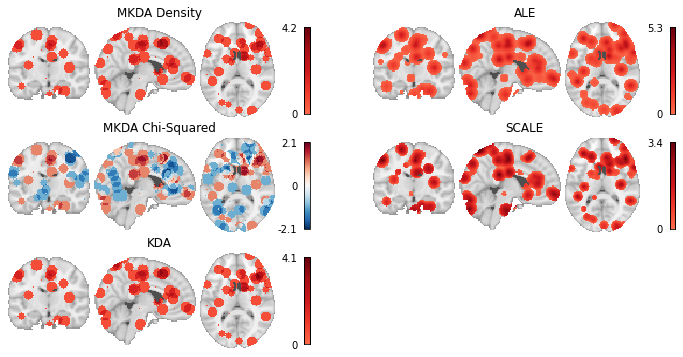

In [24]:
meta_results = {
    "MKDA Density": mkdad_img,
    "MKDA Chi-Squared": mkdac_img,
    "KDA": kda_img,
    "ALE": ale_img,
    "SCALE": scale_img,
}
order = [
    ["MKDA Density", "ALE"],
    ["MKDA Chi-Squared", "SCALE"],
    ["KDA", None]
]

fig, axes = plt.subplots(figsize=(12, 6), nrows=3, ncols=2)

for i_row, row_names in enumerate(order):
    for j_col, name in enumerate(row_names):
        if not name:
            axes[i_row, j_col].axis("off")
            continue

        img = meta_results[name]
        if name == "MKDA Chi-Squared":
            cmap = "RdBu_r"
        else:
            cmap = "Reds"

        display = plotting.plot_stat_map(
            img,
            annotate=False,
            axes=axes[i_row, j_col],
            cmap=cmap,
            cut_coords=[5, -15, 10],
            draw_cross=False,
            figure=fig,
        )
        axes[i_row, j_col].set_title(name)

        colorbar = display._cbar
        colorbar_ticks = colorbar.get_ticks()
        if colorbar_ticks[0] < 0:
            new_ticks = [colorbar_ticks[0], 0, colorbar_ticks[-1]]
        else:
            new_ticks = [colorbar_ticks[0], colorbar_ticks[-1]]
        colorbar.set_ticks(new_ticks, update_ticks=True)

glue("figure_cbma_uncorr", fig, display=False)